In [16]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [17]:
def synthetic_data(w, b, num_examples):
    """ generate y = Xw + b + noise """
    X = torch.normal(0, 1, (num_examples, len(w))) # avg=0, variance=1, shape(num * w features)
    y = torch.matmul(X, w) + b # matmul() func is matrix * matrix
    y += torch.normal(0, 0.01, y.shape) # add avg=0, variance=0.01 random noise to y
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4]) # set weight
true_b = 4.2 # set bias

features, labels = synthetic_data(true_w, true_b, 1000)

In [18]:
print("feature:", features[0], "\nlabel:", labels[0]) # show the first element and its label

feature: tensor([0.5598, 0.3553]) 
label: tensor([4.0925])


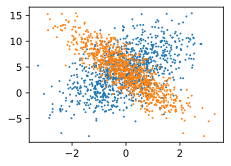

In [19]:
d2l.set_figsize()

# detach the data from gradients
# https://blog.csdn.net/u013289254/article/details/102557070 see the differences between detach(), detach_(), data

d2l.plt.scatter(features[:, 0].detach().numpy(),
                labels.detach().numpy(), 1)

d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [20]:
def data_iter(batch_size, features, labels):
    """ shuffle data into batches """
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)] # only shuffle indices instead of data
        )
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[ 0.5598,  0.3553],
        [-1.0912,  1.4046],
        [-0.3549, -0.7298],
        [ 0.2423, -1.1776],
        [ 0.2374, -1.4675],
        [-0.7523,  1.8419],
        [ 1.1518, -0.4101],
        [ 0.0358,  1.0646],
        [-1.0198,  1.3988],
        [ 1.4573,  0.7042]]) 
 tensor([[ 4.0925],
        [-2.7616],
        [ 5.9681],
        [ 8.6778],
        [ 9.6593],
        [-3.5654],
        [ 7.8925],
        [ 0.6488],
        [-2.5871],
        [ 4.7087]])


In [21]:
# initialize weight and bias
w = torch.normal(0., 0.01, (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [22]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [23]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [24]:
def sqd(params, lr, batch_size):
    """ small batch sized gradient descent """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [25]:
lr = 0.03
num_epoch = 3
net = linreg
loss = squared_loss

for epoch in range(num_epoch):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward() # l.shape is (batch_size, 1) instead of a scalar, so need a sum() to calculate the grad of [w, b]
        sqd([w, b], lr, batch_size) # small batch sized gradient descent
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean())}')

epoch 1, loss 0.03548765182495117
epoch 2, loss 0.00012033119855914265
epoch 3, loss 4.779951268574223e-05


In [27]:
print(f'residual of param w: {w.reshape(true_w.shape) - true_w}')
print(f'residual of param b: {b - true_b}')

residual of param w: tensor([0.0007, 0.0003], grad_fn=<SubBackward0>)
residual of param b: tensor([0.0001], grad_fn=<SubBackward0>)


In [29]:
# PyTorch Vesion
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [32]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [33]:
def load_array(data_arrays, batch_size, is_train=True):
    """ construct a PyTorch data iterator """
    dataset = data.TensorDataset(*data_arrays) # * means unzip tuple
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.6493, -0.1582],
         [ 0.4505,  0.8999],
         [-3.0386, -0.0397],
         [ 0.8338,  0.8094],
         [-0.6525,  0.1023],
         [-0.8773, -0.5089],
         [-0.7434,  0.3847],
         [-0.6748, -2.0611],
         [ 1.4092,  0.8334],
         [ 0.5447,  0.7751]]),
 tensor([[ 3.4503],
         [ 2.0415],
         [-1.7534],
         [ 3.1023],
         [ 2.5303],
         [ 4.1688],
         [ 1.4178],
         [ 9.8636],
         [ 4.1866],
         [ 2.6641]])]

In [34]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [36]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [37]:
loss = nn.MSELoss()

In [38]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

In [40]:
num_epochs = 3

for epoch in range(num_epoch):
    for X, y in data_iter:
        l = loss (net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000094
epoch 2, loss 0.000093
epoch 3, loss 0.000093
